## Stock Market Capitalization to GDP for United States

## Import Libraries <a name="Import-Libraries"></a>

In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

## Read Data  <a name="read-data"></a>
Time series deals with 2 columns, one is temporal ie: month in this case & another is the value to be forecasted ie: stock_gdp_us. To make plotting graphs easier, we set the index of pandas dataframe to the date. During plots, the index will act by default as the x-axis & since it has only 1 more column, that will be automatically taken as the y-axis

In [2]:
dataset = pd.read_csv('DDDM01USA156NWDB.csv')
dataset.columns = ['date', 'stock_gdp_us']
#Parse strings to datetime type
dataset['date'] = pd.to_datetime(dataset['date'],infer_datetime_format=True) #convert from string to datetime
gdp_us = dataset.set_index(['date'])
gdp_us.head(5)

,stock_gdp_us
date,
1975-01-01,40.4019
1976-01-01,42.2155
1977-01-01,41.5541
1978-01-01,36.2019
1979-01-01,35.3986


From the plot below, we can see that there is a Trend component in th series. Hence, we now check for stationarity of the data.

C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


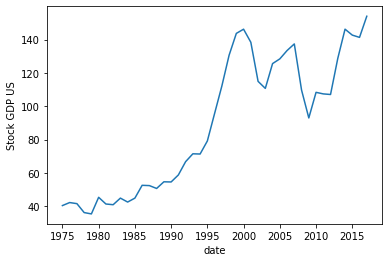

In [3]:
## plot graph
plt.xlabel('date')
plt.ylabel('Stock GDP US')
plt.plot(gdp_us)

In [4]:
#Determine rolling statistics
rolmean = gdp_us.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = gdp_us.rolling(window=12).std()
print(rolmean,rolstd)

            stock_gdp_us
date                    
1975-01-01           NaN
1976-01-01           NaN
1977-01-01           NaN
1978-01-01           NaN
1979-01-01           NaN
1980-01-01           NaN
1981-01-01           NaN
1982-01-01           NaN
1983-01-01           NaN
1984-01-01           NaN
1985-01-01           NaN
1986-01-01     42.351408
1987-01-01     43.350017
1988-01-01     44.054308
1989-01-01     45.146425
1990-01-01     46.676533
1991-01-01     48.624042
1992-01-01     50.404908
1993-01-01     52.914500
1994-01-01     55.447925
1995-01-01     58.303483
1996-01-01     62.728850
1997-01-01     68.331350
1998-01-01     74.833008
1999-01-01     82.440325
2000-01-01     90.400825
2001-01-01     97.373533
2002-01-01    102.401767
2003-01-01    106.728125
2004-01-01    111.629958
2005-01-01    116.374600
2006-01-01    121.546583
2007-01-01    126.398000
2008-01-01    127.571250
2009-01-01    125.975775
2010-01-01    124.121192
2011-01-01    121.097108
2012-01-01    117.833108


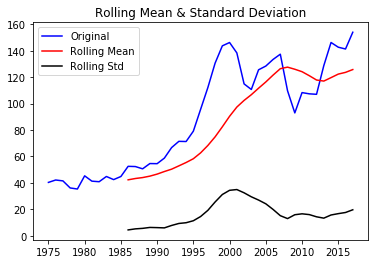

In [5]:
#Plot rolling statistics
orig = plt.plot(gdp_us, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so. 

To further augment our hypothesis that the time series is not stationary, let us perform the ADCF test.

In [6]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(gdp_us['stock_gdp_us'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -0.455348
p-value                         0.900439
#Lags Used                      5.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


For a Time series to be stationary, its ADCF test should have:
1. p-value to be low (according to the null hypothesis)
2. The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics

From the above ADCF test result, we see that p-value=0.9 is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that **our Time Series at the moment is not stationary**

## Data Transformation to achieve Stationarity <a name="data-transform"></a>

There are a couple of ways to achieve stationarity through data transformation like taking $log_{10}$,$log_{e}$, square, square root, cube, cube root, exponential decay, time shift and so on ...

In our notebook, lets start of with log transformations. Our objective is to remove the trend component. Hence,  flatter curves( ie: parallel to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.

### Log Scale Transformation  <a name="log"></a>

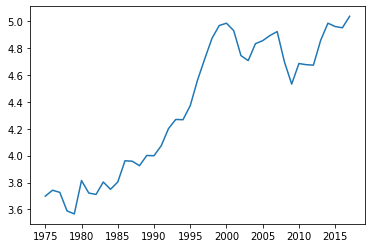

In [7]:
#Estimating trend
gdp_us_logScale = np.log(gdp_us)
plt.plot(gdp_us_logScale)

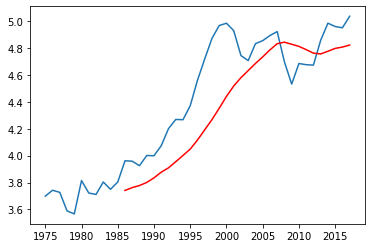

In [8]:
#The below transformation is required to make series stationary
movingAverage = gdp_us_logScale.rolling(window=12).mean()
movingSTD = gdp_us_logScale.rolling(window=12).std()
plt.plot(gdp_us_logScale)
plt.plot(movingAverage, color='red')
#plt.plot(movingSTD, color='blue')

We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:  

$log scale L = stationary part(L1) + trend(LT)$   
$moving avg of log scale A = stationary part(A1) + trend(AT)$   
$result series R = L - A = (L1+LT) - (A1+AT) = (L1-A1) + (LT-AT)$

Since, L & A are series & it moving avg, their trend will be more or less same, Hence  
LT-AT nearly equals to 0  

Thus trend component will be almost removed. And we have,  
  
$R = L1 - A1$, our final non-trend curve

In [9]:
gdp_us_logScaleMinusMovingAverage = gdp_us_logScale - movingAverage

#Remove NAN values
gdp_us_logScaleMinusMovingAverage.dropna(inplace=True)
gdp_us_logScaleMinusMovingAverage.head(10)

,stock_gdp_us
date,
1986-01-01,0.220872
1987-01-01,0.195969
1988-01-01,0.147413
1989-01-01,0.200417
1990-01-01,0.164466
1991-01-01,0.196471
1992-01-01,0.291378
1993-01-01,0.314177
1994-01-01,0.266002


In [10]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['stock_gdp_us'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

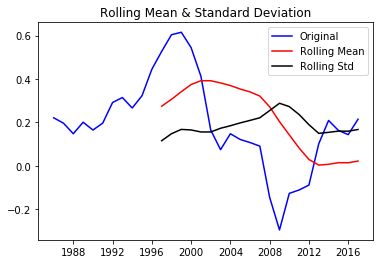

Results of Dickey Fuller Test:
Test Statistic                 -2.489356
p-value                         0.118086
#Lags Used                      8.000000
Number of Observations Used    23.000000
Critical Value (1%)            -3.752928
Critical Value (5%)            -2.998500
Critical Value (10%)           -2.638967
dtype: float64


In [11]:
test_stationarity(gdp_us_logScaleMinusMovingAverage)

From above graph, we observe that our intuition that *"subtracting two related series having similar trend components will make the result stationary"* is true. We find that:  

1. p-value has reduced from 0.9 to 0.11.  
2. The critical values at 1%,5%,10% confidence intervals are little bit close to the Test Statistic.
From above 2 points, p-value is still > than 0.05 and critical values is still a little far from Test Statistic. 

Let us try out Time Shift transformation.  


### Time Shift Transformation  <a name="shift"></a>

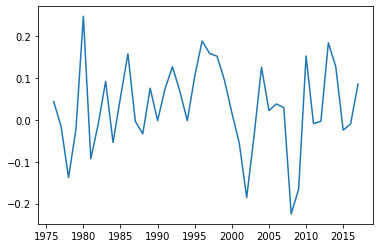

In [12]:
gdp_us_logScaleDiffShifting =  gdp_us_logScale- gdp_us_logScale.shift()
plt.plot(gdp_us_logScaleDiffShifting) 

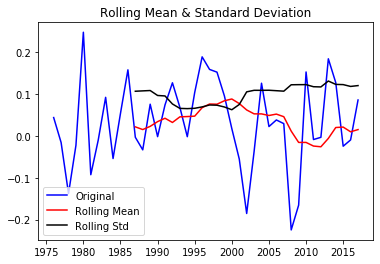

Results of Dickey Fuller Test:
Test Statistic                 -3.923146
p-value                         0.001871
#Lags Used                      3.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


In [13]:
gdp_us_logScaleDiffShifting.dropna(inplace=True)
test_stationarity(gdp_us_logScaleDiffShifting)

In [14]:
gdp_us_logScaleDiffShifting

,stock_gdp_us
date,
1976-01-01,0.043911
1977-01-01,-0.015791
1978-01-01,-0.137885
1979-01-01,-0.022439
1980-01-01,0.247994
1981-01-01,-0.092806
1982-01-01,-0.010214
1983-01-01,0.092286
1984-01-01,-0.054085


From above graphs, we can see that our series along with rolling statistic values of moving avg & moving std. dev. is  much flat & stationary. But, the ADCF test shows us that:
1. p-value went down from 0.118086 to 0.001871.  
2. Critical values is close to test values.  

So we can use the Scale Shifting

## Plotting ACF & PACF <a name="acf-pacf"></a>

C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


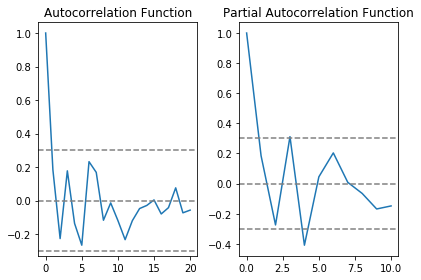

In [15]:
#ACF & PACF plots

lag_acf = acf(gdp_us_logScaleDiffShifting, nlags=20)
lag_pacf = pacf(gdp_us_logScaleDiffShifting, nlags=10, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(gdp_us_logScaleDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(gdp_us_logScaleDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(gdp_us_logScaleDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(gdp_us_logScaleDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 

From the ACF graph, we see that curve touches y=0.0 line at x=1. Thus, from theory, Q = 1
From the PACF graph, we see that curve touches y=0.0 line at x=1. Thus, from theory, P = 1

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

## Building Models <a name="model"></a>

In [16]:
gdp_us_logScaleDiffShifting

,stock_gdp_us
date,
1976-01-01,0.043911
1977-01-01,-0.015791
1978-01-01,-0.137885
1979-01-01,-0.022439
1980-01-01,0.247994
1981-01-01,-0.092806
1982-01-01,-0.010214
1983-01-01,0.092286
1984-01-01,-0.054085


### AR=(1,1,0)

In [17]:
from statsmodels.tsa.arima_model import ARIMA

model_110 = ARIMA(gdp_us_logScaleDiffShifting['stock_gdp_us'], order=(1,1,0))
model_110_fit = model_110.fit()
print(model_110_fit.summary())
print('Residuals Description')
print(model_110_fit.resid.describe())

C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(se

                             ARIMA Model Results                              
Dep. Variable:         D.stock_gdp_us   No. Observations:                   41
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  25.863
Method:                       css-mle   S.D. of innovations              0.129
Date:                Sun, 15 Sep 2019   AIC                            -45.727
Time:                        11:22:40   BIC                            -40.586
Sample:                    01-01-1977   HQIC                           -43.855
                         - 01-01-2017                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0009      0.016      0.053      0.958      -0.031       0.033
ar.L1.D.stock_gdp_us    -0.2400      0.151     -1.592      0.119      -0.535       0.055
            

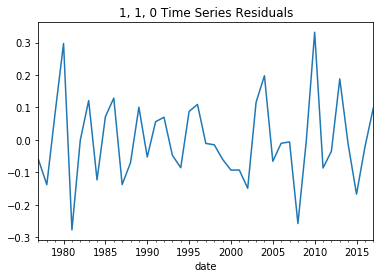

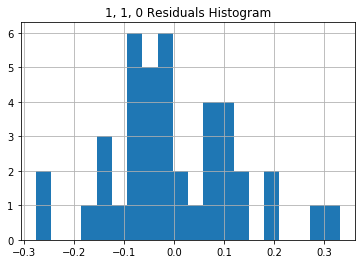

In [18]:
residuals_110 = pd.DataFrame(model_110_fit.resid)
residuals_110.plot(legend=False)
plt.title('1, 1, 0 Time Series Residuals')

residuals_110.hist(bins=20)
plt.title('1, 1, 0 Residuals Histogram')

plt.show()

### MA=(0,1,1)

C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:         D.stock_gdp_us   No. Observations:                   41
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  32.733
Method:                       css-mle   S.D. of innovations              0.104
Date:                Sun, 15 Sep 2019   AIC                            -59.466
Time:                        11:22:41   BIC                            -54.325
Sample:                    01-01-1977   HQIC                           -57.594
                         - 01-01-2017                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.028e-05      0.001     -0.023      0.982      -0.003       0.003
ma.L1.D.stock_gdp_us    -1.0000      0.088    -11.327      0.000      -1.173      -0.827
            

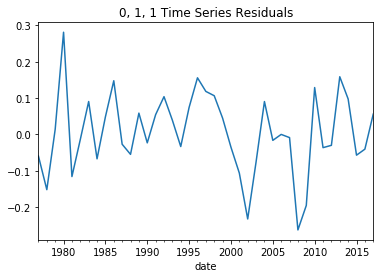

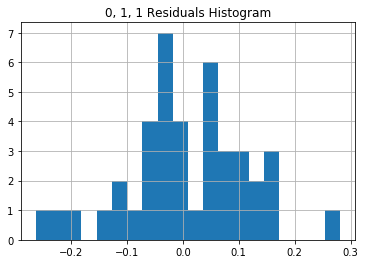

In [19]:
from statsmodels.tsa.arima_model import ARIMA

model_011 = ARIMA(gdp_us_logScaleDiffShifting['stock_gdp_us'], order=(0,1,1))
model_011_fit = model_011.fit()
print(model_011_fit.summary())
print('Residuals Description')
print(model_011_fit.resid.describe())

residuals_011 = pd.DataFrame(model_011_fit.resid)
residuals_011.plot(legend=False)
plt.title('0, 1, 1 Time Series Residuals')

residuals_011.hist(bins=20)
plt.title('0, 1, 1 Residuals Histogram')

plt.show()

### AR+I+MA

C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:         D.stock_gdp_us   No. Observations:                   41
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  33.634
Method:                       css-mle   S.D. of innovations              0.102
Date:                Sun, 15 Sep 2019   AIC                            -59.268
Time:                        11:22:41   BIC                            -52.414
Sample:                    01-01-1977   HQIC                           -56.772
                         - 01-01-2017                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 8.495e-06      0.002      0.005      0.996      -0.003       0.003
ar.L1.D.stock_gdp_us     0.2088      0.155      1.348      0.186      -0.095       0.512
ma.L1.D.stoc

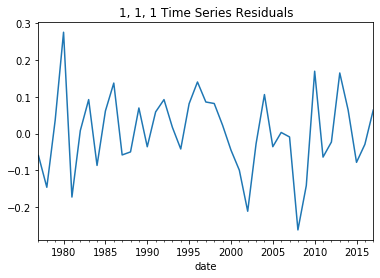

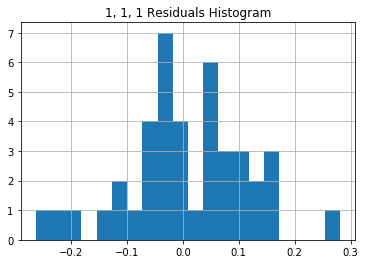

In [20]:
from statsmodels.tsa.arima_model import ARIMA

model_111 = ARIMA(gdp_us_logScaleDiffShifting['stock_gdp_us'], order=(1,1,1))
model_111_fit = model_111.fit()
print(model_111_fit.summary())
print('Residuals Description')
print(model_111_fit.resid.describe())

residuals_111 = pd.DataFrame(model_111_fit.resid)
residuals_111.plot(legend=False)
plt.title('1, 1, 1 Time Series Residuals')

residuals_011.hist(bins=20)
plt.title('1, 1, 1 Residuals Histogram')

plt.show()

### order=(2,0,1)

C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:           stock_gdp_us   No. Observations:                   42
Model:                     ARMA(2, 1)   Log Likelihood                  42.855
Method:                       css-mle   S.D. of innovations              0.084
Date:                Sun, 15 Sep 2019   AIC                            -75.710
Time:                        11:22:42   BIC                            -67.021
Sample:                    01-01-1976   HQIC                           -72.525
                         - 01-01-2017                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0326      0.016      2.056      0.047       0.002       0.064
ar.L1.stock_gdp_us    -0.4504      0.152     -2.956      0.005      -0.749      -0.152
ar.L2.stock_gdp_us  

C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


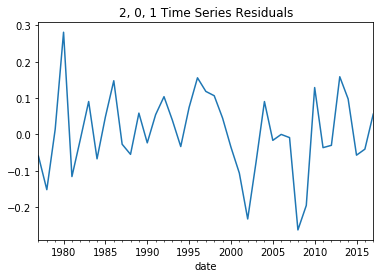

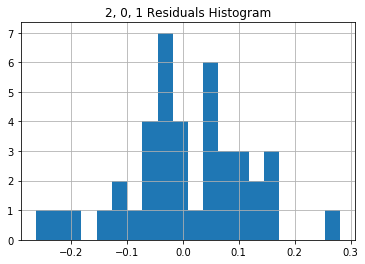

In [21]:
from statsmodels.tsa.arima_model import ARIMA

model_201 = ARIMA(gdp_us_logScaleDiffShifting['stock_gdp_us'], order=(2,0,1))
model_201_fit = model_201.fit()
print(model_201_fit.summary())
print('Residuals Description')
print(model_201_fit.resid.describe())

residuals_201 = pd.DataFrame(model_011_fit.resid)
residuals_201.plot(legend=False)
plt.title('2, 0, 1 Time Series Residuals')

residuals_011.hist(bins=20)
plt.title('2, 0, 1 Residuals Histogram')

plt.show()

### order=(2,1,2)

C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:         D.stock_gdp_us   No. Observations:                   41
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  39.661
Method:                       css-mle   S.D. of innovations              0.085
Date:                Sun, 15 Sep 2019   AIC                            -67.322
Time:                        11:22:43   BIC                            -57.040
Sample:                    01-01-1977   HQIC                           -63.578
                         - 01-01-2017                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0002      0.001     -0.157      0.876      -0.003       0.002
ar.L1.D.stock_gdp_us    -0.4311      0.155     -2.772      0.009      -0.736      -0.126
ar.L2.D.stoc

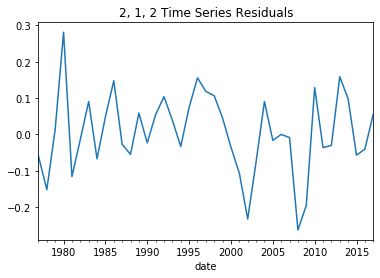

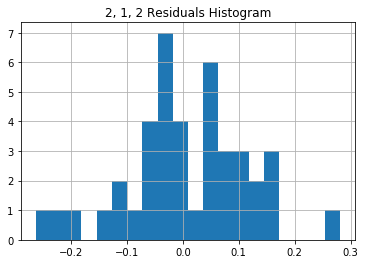

In [22]:
from statsmodels.tsa.arima_model import ARIMA

model_212 = ARIMA(gdp_us_logScaleDiffShifting['stock_gdp_us'], order=(2,1,2))
model_212_fit = model_212.fit()
print(model_212_fit.summary())
print('Residuals Description')
print(model_212_fit.resid.describe())

residuals_212 = pd.DataFrame(model_011_fit.resid)
residuals_212.plot(legend=False)
plt.title('2, 1, 2 Time Series Residuals')

residuals_011.hist(bins=20)
plt.title('2, 1, 2 Residuals Histogram')

plt.show()

C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:           stock_gdp_us   No. Observations:                   42
Model:                     ARMA(2, 2)   Log Likelihood                  42.893
Method:                       css-mle   S.D. of innovations              0.084
Date:                Sun, 15 Sep 2019   AIC                            -73.786
Time:                        11:22:43   BIC                            -63.360
Sample:                    01-01-1976   HQIC                           -69.965
                         - 01-01-2017                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0327      0.016      2.016      0.051       0.001       0.064
ar.L1.stock_gdp_us    -0.6065      0.534     -1.136      0.263      -1.653       0.440
ar.L2.stock_gdp_us  

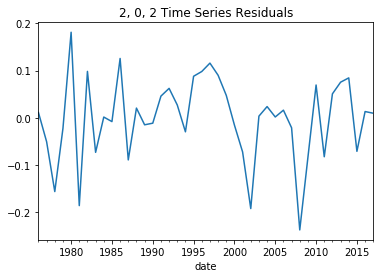

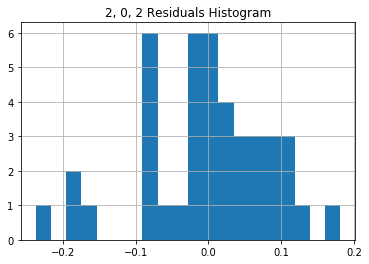

In [23]:
from statsmodels.tsa.arima_model import ARIMA

model_202 = ARIMA(gdp_us_logScaleDiffShifting['stock_gdp_us'], order=(2,0,2))
model_202_fit = model_202.fit()
print(model_202_fit.summary())
print('Residuals Description')
print(model_202_fit.resid.describe())

residuals_202 = pd.DataFrame(model_202_fit.resid)
residuals_202.plot(legend=False)
plt.title('2, 0, 2 Time Series Residuals')

residuals_202.hist(bins=20)
plt.title('2, 0, 2 Residuals Histogram')

plt.show()

* The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic. When comparing two models, the one with the __lower AIC is generally “better”__.



The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic. When comparing two models, the one with the lower AIC is generally “better”.

AIC(1,1,0)= -45.727
AIC(0,1,1)= -59.466
AIC(1,1,1)= -59.268
AIC(2,1,2)= -67.322
AIC(2,0,1)= -75.710

#### The ARIMA Model(2,0,1) is the one that performing best, it AIC is -75 and p-value majority is >0.05.  

C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Plotting AR model


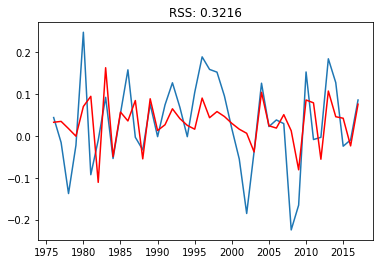

In [27]:
#ARIMA Model
model = ARIMA(gdp_us_logScaleDiffShifting, order=(2,0,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(gdp_us_logScaleDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - gdp_us_logScaleDiffShifting['stock_gdp_us'])**2))
print('Plotting AR model')

Plotting MA model


C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


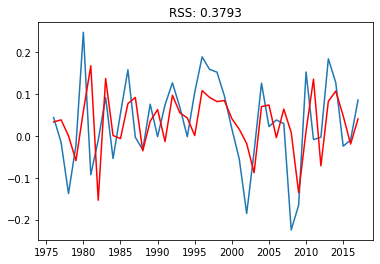

In [28]:
#MA Model
model = ARIMA(gdp_us_logScaleDiffShifting, order=(0,0,1))
results_MA = model.fit(disp=-1)
plt.plot(gdp_us_logScaleDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - gdp_us_logScaleDiffShifting['stock_gdp_us'])**2))
print('Plotting MA model')

Plotting ARIMA model


C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


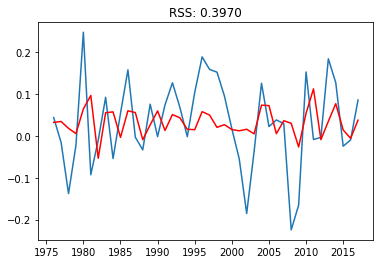

In [29]:
# AR model
model = ARIMA(gdp_us_logScaleDiffShifting, order=(2,0,0))
results_AR = model.fit(disp=-1)
plt.plot(gdp_us_logScaleDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - gdp_us_logScaleDiffShifting['stock_gdp_us'])**2))
print('Plotting ARIMA model')

#### By combining AR & MA into ARIMA, we see that RSS value ARIMA(0.3216) is the lowest compare w/ AR(0.3970) & MA(0.3793) , indicating ARIMA to be better than its individual component models.   

In [59]:
AIC_111= -59.268
AIC_212= -67.322
AIC_201= -75.710
loss_201 = np.exp((67-75)/2)
print(loss_201)
loss_111 = np.exp((59-67)/2)
print(loss_111)

54.598150033144236
54.598150033144236


### With the ARIMA model built, we will now generate predictions. But, before we do any plots for predictions ,we need to recover the predictions back to original form. This is because, our model was built on log transformed data.

## Prediction & Reverse transformations <a name="prediction"></a>

In [ ]:
var array = ['Dog', 'Cat', 'Animal', 'Pig'];

array.push(array.shift());
console.log(array); // ["Cat", "Animal", "Pig", "Dog"]

array = ['Dog', 'Cat', 'Animal', 'Pig'];

array.unshift(array.pop());
console.log(array); // ["Pig", "Dog", "Cat", "Animal"]

In [31]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
1976-01-01    0.032649
1977-01-01    0.034735
1978-01-01    0.017456
1979-01-01   -0.000677
1980-01-01    0.070397
dtype: float64


In [32]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

date
1976-01-01    0.032649
1977-01-01    0.067383
1978-01-01    0.084839
1979-01-01    0.084163
1980-01-01    0.154560
1981-01-01    0.249283
1982-01-01    0.138177
1983-01-01    0.301276
1984-01-01    0.251585
1985-01-01    0.308647
1986-01-01    0.344426
1987-01-01    0.429061
1988-01-01    0.374152
1989-01-01    0.463006
1990-01-01    0.475871
1991-01-01    0.502550
1992-01-01    0.567442
1993-01-01    0.608884
1994-01-01    0.634069
1995-01-01    0.650135
1996-01-01    0.740662
1997-01-01    0.784195
1998-01-01    0.842427
1999-01-01    0.888848
2000-01-01    0.918886
2001-01-01    0.934963
2002-01-01    0.941214
2003-01-01    0.902865
2004-01-01    1.007087
2005-01-01    1.031323
2006-01-01    1.050050
2007-01-01    1.100892
2008-01-01    1.113201
2009-01-01    1.032162
2010-01-01    1.118088
2011-01-01    1.197255
2012-01-01    1.141467
2013-01-01    1.248804
2014-01-01    1.294699
2015-01-01    1.336994
2016-01-01    1.313130
2017-01-01    1.389005
dtype: float64


In [33]:
predictions_ARIMA_log = pd.Series(gdp_us_logScaleDiffShifting['stock_gdp_us'].iloc[0], 
                                  index=gdp_us_logScaleDiffShifting.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

date
1976-01-01    0.076559
1977-01-01    0.111294
1978-01-01    0.128750
1979-01-01    0.128073
1980-01-01    0.198471
dtype: float64

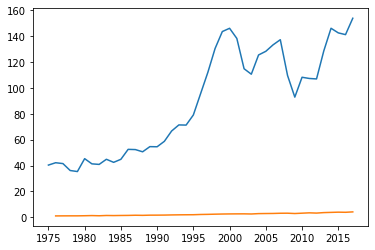

In [34]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(gdp_us)
plt.plot(predictions_ARIMA)

We see that our predicted forecasts are very close to the real time series values indicating a fairly accurate model.

In [49]:
gdp_us_logScaleDiffShifting.stock_gdp_us

date
1976-01-01    0.043911
1977-01-01   -0.015791
1978-01-01   -0.137885
1979-01-01   -0.022439
1980-01-01    0.247994
1981-01-01   -0.092806
1982-01-01   -0.010214
1983-01-01    0.092286
1984-01-01   -0.054085
1985-01-01    0.053989
1986-01-01    0.158045
1987-01-01   -0.003257
1988-01-01   -0.033349
1989-01-01    0.075848
1990-01-01   -0.001763
1991-01-01    0.074250
1992-01-01    0.127075
1993-01-01    0.068401
1994-01-01   -0.001878
1995-01-01    0.104061
1996-01-01    0.189103
1997-01-01    0.159047
1998-01-01    0.152537
1999-01-01    0.095584
2000-01-01    0.017388
2001-01-01   -0.055271
2002-01-01   -0.185577
2003-01-01   -0.037391
2004-01-01    0.126048
2005-01-01    0.022352
2006-01-01    0.038159
2007-01-01    0.029365
2008-01-01   -0.224881
2009-01-01   -0.165591
2010-01-01    0.152959
2011-01-01   -0.008688
2012-01-01   -0.003349
2013-01-01    0.184484
2014-01-01    0.127491
2015-01-01   -0.024657
2016-01-01   -0.009594
2017-01-01    0.085907
Name: stock_gdp_us, dtype: fl

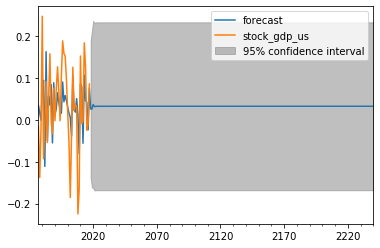

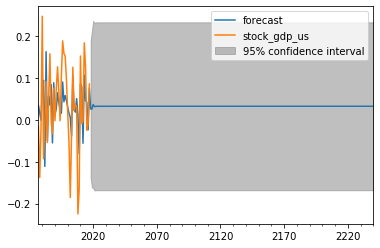

In [51]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,264) 
#x=results_ARIMA.forecast(steps=120)

Im not sure if this is correct coz I didn't unshift it, Ask istructor how to convert unshift the data.